# Trading Strategy with Clustering Stocks data

## Impomporting libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm
import datetime as dt
import yfinance as yf
import talib
import pandas_datareader.data as web
from sklearn.cluster import KMeans
from pypfopt import risk_models, expected_returns
from pypfopt.efficient_frontier import EfficientFrontier

## Data Collollection and Prepreprocessing

**Downloading data**
- We download the S&P500 Stocks Symbols from it's wikipedia page.
- We use the symbols to download the stock data from yahoo finance.

In [2]:
def get_symbols_list(url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'):
    """
    Fetch and return a list of S&P 500 company symbols from Wikipedia.

    Parameters:
    url (str): URL to fetch the S&P 500 list from. Defaults to Wikipedia's S&P 500 page.

    Returns:
    list: A list of S&P 500 company symbols formatted for yfinance.
    """
    try:
        # Fetch the table from the provided URL
        sp500 = pd.read_html(url)[0]

        # Ensure the 'Symbol' column exists
        if 'Symbol' not in sp500.columns:
            raise ValueError("The 'Symbol' column is missing from the fetched data.")

        # Replace '.' with '-' in symbols for yfinance compatibility
        sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')

        # Get unique symbols and convert to list
        symbols_list = sp500['Symbol'].unique().tolist()

        return symbols_list

    except Exception as e:
        raise RuntimeError(f"Error fetching S&P 500 symbols: {e}")

symbols_list = get_symbols_list()

In [3]:
#print(symbols_list)
#symbols_list

In [4]:
def download_stock_data(symbols_list, start_date, end_date, chunk_size = 100):
    """
    Download stock data in chunks to avoid overloading the API.

    Parameters:
    symbols_list (list): List of stock symbols to fetch.
    start_date (str or pd.Timestamp): Start date for data download.
    end_date (str or pd.Timestamp): End date for data download.
    chunk_size (int): Number of symbols to fetch per chunk.

    Returns:
    pd.DataFrame: Combined DataFrame with stock data.
    """
    try:
        all_data = []

        # Iterate over chunks of symbols
        for i in range(0, len(symbols_list), chunk_size):
            chunk = symbols_list[i: i + chunk_size]

            try:
                # Download data for the current chunk
                data = yf.download(tickers = chunk, start = start_date, end = end_date).stack(future_stack = True)
                data.index.names = ['date', 'ticker']
                data.columns = data.columns.str.lower()
                all_data.append(data)
            except Exception as e:
                raise RuntimeError(f"Error fetching data for chunk {chunk}: {e}")

        # Combine all chunks into a single DataFrame
        if all_data:
            df = pd.concat(all_data)
        else:
            raise RuntimeError("No data was fetched. Please check your symbols list and dates.")

        return df

    except Exception as e:
        raise RuntimeError(f"Error: {e}")

end_date = '2024-08-03'
start_date = pd.to_datetime(end_date) - pd.DateOffset(years=8)

df = download_stock_data(symbols_list, start_date, end_date)

[*********************100%%**********************]  100 of 100 completed
[*********************100%%**********************]  100 of 100 completed
[*********************100%%**********************]  100 of 100 completed
[*********************100%%**********************]  100 of 100 completed
[*********************100%%**********************]  100 of 100 completed
[*********************100%%**********************]  3 of 3 completed


In [5]:
#print(df.head())
df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2016-08-03 A        44.222778   47.090000   47.180000   46.900002   47.099998   
           AAL      32.271358   33.480000   33.959999   33.169998   33.470001   
           AAPL     24.263592   26.447500   26.459999   26.192499   26.202499   
           ABBV     47.158066   66.570000   67.000000   66.220001   66.809998   
           ABNB           NaN         NaN         NaN         NaN         NaN   
...                       ...         ...         ...         ...         ...   
2024-08-01 ZBRA    342.579987  342.579987  353.859985  334.299988  350.420013   
           ZTS     182.419998  182.419998  183.929993  180.600006  181.050003   
2024-08-02 ZBH     110.360001  110.360001  111.930000  108.820000  111.220001   
           ZBRA    322.299988  322.299988  332.130005  319.040009  331.799988   
           ZTS     180.589996  180.589996  183.529999  178.529999  181.600006   

Price                   volume  
date       ticker               
2016-08-03 A         1508900.0  
           AAL       8254200.0  
           AAPL    120810400.0  
           ABBV      6355100.0  
           ABNB            NaN  
...                        ...  
2024-08-01 ZBRA       580900.0  
           ZTS       1987800.0  
2024-08-02 ZBH       1190000.0  
           ZBRA       447800.0  
           ZTS       2699600.0  

[1012539 rows x 6 columns]

**Calculate features and technical indicators for each stock**
- Garman-Klass Volatility:
  - The Garman-Klass volatility estimator is a method to calculate historical volatility, accounting for the open, close, high, and low prices of an asset. It improves upon the simple close-to-close volatility by incorporating the intraday price range.

In [6]:
# Garman-Klass Volatility Calculation
def calculate_gk_volatility(df):
    """
    Calculate Garman-Klass volatility for a given DataFrame.

    Parameters:
    df (pd.DataFrame): DataFrame containing 'high', 'low', 'adj close', and 'open' columns.

    Returns:
    pd.Series: Series with the Garman-Klass volatility.
    """
    try:
        # Ensure necessary columns are present
        #required_columns = ['high', 'low', 'adj close', 'open']
        #if not all(col in df.columns for col in required_columns):
        #    raise ValueError(f"DataFrame must contain the following columns: {required_columns}")

        # Calculate Garman-Klass volatility
        return (((np.log(df['high']) - np.log(df['low'])) ** 2) / 2 - 
                (2 * np.log(2) - 1) * ((np.log(df['adj close']) - np.log(df['open'])) ** 2))

    except Exception as e:
        raise RuntimeError(f"Error calculating Garman-Klass volatility: {e}")

df['garman_klass_vol'] = df.apply(calculate_gk_volatility, axis = 1)

- Relative Strength Index (RSI):
  - RSI is a momentum oscillator that measures the speed and change of price movements. It ranges from 0 to 100, where values above 70 generally indicate overbought conditions and below 30 indicate oversold conditions.

In [7]:
# RSI Calculation
def calculate_rsi(series, window = 14):
    """
    Calculate the Relative Strength Index (RSI) for a given series.

    Parameters:
    series (pd.Series): Price series to calculate RSI.
    window (int): The window size for RSI calculation.

    Returns:
    pd.Series: RSI values.
    """
    try:
        # Calculate RSI using TA-Lib
        return talib.RSI(series, timeperiod = window)
    except Exception as e:
        raise RuntimeError(f"Error calculating RSI: {e}")

# def calculate_rsi(series, window = 14):
#     delta = series.diff()
#     gain = (delta.where(delta > 0, 0)).fillna(0)
#     loss = (-delta.where(delta < 0, 0)).fillna(0)
#     avg_gain = gain.rolling (window = window, min_periods = 1).mean()
#     avg_loss = loss.rolling(window = window, min_periods = 1).mean()
#     rs = avg_gain / avg_loss
#     rsi = 100 - (100 / (1 + rs))
#     return rsi

df['rsi'] = df.groupby(level = 1)['adj close'].transform(lambda x: calculate_rsi(x, window = 14))

- Bollinger Bands(bb_low, bb_mid, bb_high):
  - Bollinger Bands consist of a middle band (a simple moving average) and an upper and lower band, which are typically two standard deviations away from the middle band. They are used to identify overbought and oversold conditions.

In [8]:
# Bollinger Bands Calculation
def calculate_bbands(series, window = 20):
    """
    Calculate the Bollinger Bands for a given series.

    Parameters:
    series (pd.Series): Price series to calculate Bollinger Bands.
    window (int): The window size for Bollinger Bands calculation.

    Returns:
    tuple(pd.Series, pd.Series, pd.Series): Lower band, middle band, and upper band.
    """
    try:
        # Calculate Bollinger Bands using TA-Lib
        upper, middle, lower = talib.BBANDS(series, timeperiod = window, nbdevup = 2, nbdevdn = 2, matype = 0)
        return lower, middle, upper
    except Exception as e:
        raise RuntimeError(f"An error occurred while calculating Bollinger Bands: {e}")

# def calculate_bbands(series, window = 20):
#     # Calculate the moving average (middle band)
#     middle = series.rolling(window = window, min_periods = 1).mean()
#     # Calculate the rolling standard deviation
#     rolling_std = series.rolling(window = window, min_periods = 1).std()
#     # Calculate the upper and lower bands
#     lower = middle - (rolling_std * 2)
#     upper = middle + (rolling_std * 2)
#     return lower, middle, upper

df['bb_low'] =  df.groupby(level = 1)['adj close'].transform(lambda x: calculate_bbands(np.log1p(x), window = 20)[0])
df['bb_mid'] = df.groupby(level = 1)['adj close'].transform(lambda x: calculate_bbands(np.log1p(x), window = 20)[1])
df['bb_high'] = df.groupby(level = 1)['adj close'].transform(lambda x: calculate_bbands(np.log1p(x), window = 20)[2])

- Average True Range (ATR):
  - ATR is a measure of volatility, typically used to gauge market risk. It calculates the average range of price movements (true range) over a specific period.

In [9]:
# ATR Calculation
def calculate_atr(dframe, window = 14):
    """
    Calculate the Average True Range for a given DataFrame.

    Parameters:
    dframe (pd.DataFrame): DataFrame containing the 'high', 'low', and 'close' columns.
    window (int): The window size for ATR calculation.

    Returns:
    pd.Series: ATR values.
    """
    # Check for required columns
    required_columns = ['high', 'low', 'close']
    if not all(col in dframe.columns for col in required_columns):
        raise ValueError(f"DataFrame is missing required columns: {required_columns}")

    # Check that columns contain numeric data
    try:
        # Calculate ATR using TA-Lib
        atr = talib.ATR(dframe['high'], dframe['low'], dframe['close'], timeperiod = window)

        return (atr - atr.mean()) / atr.std()
    except Exception as e:
        raise RuntimeError(f"An error occurred while calculating ATR: {e}")

# def calculate_atr(df, window = 14):
#     high_low = df['high'] - df['low']
#     high_close = np.abs(df['high'] - df['close'].shift())
#     low_close = np.abs(df['low'] - df['close'].shift())
#     tr = high_low.combine(high_close, np.maximum).combine(low_close, np.maximum)
#     atr = tr.rolling(window = window, min_periods = 1).mean()
#     normalized_atr = (atr - atr.mean()) / atr.std()
#     return normalized_atr

df['atr'] = df.groupby(level = 1, group_keys = False).apply(calculate_atr, window = 14)

- Moving Average Convergence Divergence (MACD):
  - MACD is a trend-following momentum indicator that shows the relationship between two moving averages of a security’s price. It consists of the MACD line (difference between the 12-day and 26-day EMAs) and the signal line (9-day EMA of the MACD line).

In [10]:
# MACD Calculation
def calculate_macd(close, fastperiod = 12, slowperiod = 26, signalperiod = 9):
    """
    Calculate the Moving Average Convergence Divergence (MACD) for a given DataFrame.

    Parameters:
    close (pd.Series): DataFrame containing the 'close' column.
    fastperiod (int, optional): The fast period for MACD calculation. Defaults to 12.
    slowperiod (int, optional): The slow period for MACD calculation. Defaults to 26.
    signalperiod (int, optional): The signal period for MACD calculation. Defaults to 9.

    Returns:
    pd.Series: MACD values.
    """
    try:
        # Calculate MACD using TA-Lib
        macd, macdsignal, macdhist = talib.MACD(close, fastperiod = fastperiod, slowperiod = slowperiod, signalperiod = signalperiod)

        return (macd - macd.mean()) / macd.std()
    except Exception as e:
        raise RuntimeError(f"An error occurred while calculating MACD: {e}")

# def calculate_macd(series, fastperiod = 12, slowperiod = 26, signalperiod = 9):
#     fast_ema = series.ewm(span = fastperiod, min_periods = 1).mean()
#     slow_ema = series.ewm(span = slowperiod, min_periods = 1).mean()
#     signal = macd.ewm(span = signalperiod, min_periods = 1).mean()
#     macd = fast_ema - slow_ema
#     normalized_macd = (macd - macd.mean()) / macd.std()
#     return normalized_macd

df['macd'] = df.groupby(level = 1, group_keys = False)['adj close'].apply(calculate_macd)

- Dollar Volume:
  - Dollar volume is the total value traded of a security, calculated as the product of the price and the number of shares traded.

In [11]:
# Dollar Volume Calculation
df['dollar_volume'] = (df['adj close'] * df['volume']) / 1e6

In [12]:
# print(df.head())
df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2016-08-03 A        44.222778   47.090000   47.180000   46.900002   47.099998   
           AAL      32.271358   33.480000   33.959999   33.169998   33.470001   
           AAPL     24.263592   26.447500   26.459999   26.192499   26.202499   
           ABBV     47.158066   66.570000   67.000000   66.220001   66.809998   
           ABNB           NaN         NaN         NaN         NaN         NaN   
...                       ...         ...         ...         ...         ...   
2024-08-01 ZBRA    342.579987  342.579987  353.859985  334.299988  350.420013   
           ZTS     182.419998  182.419998  183.929993  180.600006  181.050003   
2024-08-02 ZBH     110.360001  110.360001  111.930000  108.820000  111.220001   
           ZBRA    322.299988  322.299988  332.130005  319.040009  331.799988   
           ZTS     180.589996  180.589996  183.529999  178.529999  181.600006   

Price                   volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2016-08-03 A         1508900.0         -0.001517        NaN       NaN   
           AAL       8254200.0         -0.000237        NaN       NaN   
           AAPL    120810400.0         -0.002231        NaN       NaN   
           ABBV      6355100.0         -0.046807        NaN       NaN   
           ABNB            NaN               NaN        NaN       NaN   
...                        ...               ...        ...       ...   
2024-08-01 ZBRA       580900.0          0.001419  62.554626  5.734028   
           ZTS       1987800.0          0.000145  60.659356  5.160969   
2024-08-02 ZBH       1190000.0          0.000374  51.436339  4.670789   
           ZBRA       447800.0          0.000482  48.004735  5.740452   
           ZTS       2699600.0          0.000369  55.796520  5.164529   

Price                bb_mid   bb_high       atr      macd  dollar_volume  
date       ticker                                                         
2016-08-03 A            NaN       NaN       NaN       NaN      66.727750  
           AAL          NaN       NaN       NaN       NaN     266.374247  
           AAPL         NaN       NaN       NaN       NaN    2931.294227  
           ABBV         NaN       NaN       NaN       NaN     299.694224  
           ABNB         NaN       NaN       NaN       NaN            NaN  
...                     ...       ...       ...       ...            ...  
2024-08-01 ZBRA    5.795394  5.856761  0.683432  0.901341     199.004714  
           ZTS     5.192383  5.223798  0.711151  0.706492     362.614472  
2024-08-02 ZBH     4.705167  4.739545 -0.445794  0.181976     131.328401  
           ZBRA    5.797252  5.854051  0.901846  0.704969     144.325935  
           ZTS     5.194076  5.223623  0.759218  0.652054     487.520754  

[1012539 rows x 14 columns]

**Monthly Aggregation and Selection of Top 150 Liquid Stocks**
- For efficiency in training and to facilitate experimentation with various features and strategies, we aggregate the business-daily data to reflect month-end frequencies.

In [13]:
def dollar_volume_monthly_aggregation(df):
    """
    Aggregate monthly dollar volume data to reflect month-end frequencies.

    Parameters:
    df (pd.DataFrame): DataFrame containing the 'dollar_volume' column.

    Returns:
    pd.DataFrame: DataFrame containing the monthly dollar volume data.
    """
    try:
        # Validate that 'ticker' is in the index and 'dollar_volume' is a column
        if 'ticker' not in df.index.names:
            raise ValueError("'ticker' must be in the DataFrame index.")
        if 'dollar_volume' not in df.columns:
            raise ValueError("'dollar_volume' must be a column in the DataFrame.")

        # Define columns to exclude
        exclude_cols = {'dollar_volume', 'volume', 'open', 'high', 'low', 'close'}

        # Filter columns to keep
        indicator_cols = [c for c in df.columns if c not in exclude_cols]

        # Check if there are columns left after exclusion
        if not indicator_cols:
            raise ValueError("No columns left after exclusion.")

        # Resample and process 'dollar_volume'
        dollar_volume_resampled = df.unstack('ticker')['dollar_volume'].resample('ME').mean().stack('ticker', future_stack = True).to_frame('dollar_volume')

        # Resample and process remaining columns
        remaining_data_resampled = df.unstack('ticker')[indicator_cols].resample('ME').last().stack('ticker', future_stack = True)

        # Concatenate dataframes and drop NA values
        data = pd.concat([dollar_volume_resampled, remaining_data_resampled], axis=1).dropna()

        return data

    except (ValueError, KeyError) as e:
        raise RuntimeError(f"An error occurred during data processing: {e}")

data = dollar_volume_monthly_aggregation(df)

In [14]:
#print(data.head())
data

dollar_volume   adj close  garman_klass_vol        rsi  \
date       ticker                                                           
2016-09-30 A           79.965590   44.332638         -0.000643  56.325666   
           AAL        272.390861   35.288368          0.000336  55.878246   
           AAPL      4725.075114   26.069180         -0.002108  58.398935   
           ABBV       296.328719   44.678673         -0.044150  40.662305   
           ABT        277.293764   36.531704         -0.006690  49.870119   
...                          ...         ...               ...        ...   
2024-08-31 XYL        207.438960  130.149994          0.000337  36.841372   
           YUM        265.027927  135.179993          0.000351  62.828624   
           ZBH        128.441446  110.360001          0.000374  51.436339   
           ZBRA       171.665324  322.299988          0.000482  48.004735   
           ZTS        425.067613  180.589996          0.000369  55.796520   

                     bb_low    bb_mid   bb_high       atr      macd  
date       ticker                                                    
2016-09-30 A       3.754324  3.791448  3.828571 -1.349226 -0.195842  
           AAL     3.517487  3.587081  3.656676  0.195335  0.081480  
           AAPL    3.218132  3.280841  3.343550 -1.235560 -0.164411  
           ABBV    3.812678  3.834058  3.855438 -1.528762 -0.470040  
           ABT     3.588636  3.612017  3.635397 -1.265433 -0.489742  
...                     ...       ...       ...       ...       ...  
2024-08-31 XYL     4.882547  4.927043  4.971539  1.950467 -0.752904  
           YUM     4.831162  4.870143  4.909125  0.886026 -0.084823  
           ZBH     4.670789  4.705167  4.739545 -0.445794  0.181976  
           ZBRA    5.740452  5.797252  5.854051  0.901846  0.704969  
           ZTS     5.164529  5.194076  5.223623  0.759218  0.652054  

[47274 rows x 9 columns]

- Select the 150 most liquid stocks based on 5-year rolling average of dollar volume

In [15]:
def select_top_liquid_stocks(data):
    """
    Select the 150 most liquid stocks based on 5-year rolling average of dollar volume.

    Parameters:
    data (pd.DataFrame): DataFrame containing the monthly dollar volume data.

    Returns:
    pd.DataFrame: DataFrame containing the 150 most liquid stocks.
    """
    try:
        # Validate required columns
        if 'dollar_volume' not in data.columns:
            raise ValueError("'dollar_volume' must be a column in the DataFrame.")

        if 'ticker' not in data.index.names:
            raise ValueError("'ticker' must be in the DataFrame index.")

        if 'date' not in data.index.names:
            raise ValueError("'date' must be in the DataFrame index.")

        # Perform rolling mean, ranking, filtering, and column dropping
        data = (
            data
            .assign(
                dollar_volume = lambda df: df['dollar_volume']
                .unstack(level = 'ticker')
                .rolling(window = 5*12, min_periods = 12)
                .mean()
                .stack(level = 'ticker')
                )
                .assign(
                    dollar_volume_rank = lambda df: df
                    .groupby(level = 'date')['dollar_volume']
                    .rank(ascending = False)
                    )
                    .query('dollar_volume_rank < 150')
                    .drop(columns = ['dollar_volume', 'dollar_volume_rank'], errors = 'ignore')
            )

        return data

    except (KeyError, ValueError) as e:
        raise RuntimeError(f"An error occurred during data processing: {e}")

data = select_top_liquid_stocks(data)

In [16]:
#print(data.head())
data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2017-08-31 AAL      43.511295         -0.000146  36.140020  3.741600   
           AAPL     38.485275         -0.001422  67.733423  3.621129   
           ABBV     55.412041         -0.032460  73.238606  3.944742   
           ABT      45.090450         -0.004445  65.081068  3.773206   
           ACN     117.201645         -0.004114  61.104790  4.746614   
...                       ...               ...        ...       ...   
2024-08-31 VRTX    494.459991          0.000610  55.716051  6.179781   
           VZ       40.970001          0.000678  55.513230  3.687818   
           WFC      52.856209          0.000592  30.061903  4.028187   
           WMT      68.265411          0.000512  45.326237  4.239454   
           XOM     115.946533          0.000434  54.199766  4.710706   

                     bb_mid   bb_high       atr      macd  
date       ticker                                          
2017-08-31 AAL     3.839023  3.936447  0.380882 -1.847717  
           AAPL    3.649403  3.677678 -1.152026 -0.012842  
           ABBV    3.983809  4.022875 -1.526028  0.055547  
           ABT     3.799478  3.825750 -1.351499  0.065770  
           ACN     4.759914  4.773213 -1.341148 -0.060976  
...                     ...       ...       ...       ...  
2024-08-31 VRTX    6.201416  6.223050  1.795722  1.283314  
           VZ      3.729524  3.771230  0.034957  0.051459  
           WFC     4.086512  4.144836  1.571327 -0.653599  
           WMT     4.258672  4.277890  1.267903  0.331228  
           XOM     4.749947  4.789188  0.816455  0.608096  

[12665 rows x 8 columns]

**Generating Features by Calculating Monthly Returns Over Various Time Periods**
- We calculate historical returns using the .pct_change(lag) method to capture the dynamics of time series, such as momentum trends. This process involves calculating returns across various monthly time intervals defined by lags.

In [17]:
def calculate_returns(df):
    """
    Calculate returns for various lags and clip outliers.

    Parameters:
    df (pd.DataFrame): DataFrame with 'adj close' column.

    Returns:
    pd.DataFrame: DataFrame with additional return columns for different lags.
    """
    try:
        # Validate presence of 'adj close' column
        if 'adj close' not in df.columns:
            raise ValueError("'adj close' column is missing from the DataFrame.")

        outlier_cutoff = 0.005
        lags = [1, 2, 3, 6, 9, 12]

        # Function to calculate and clip returns
        def calculate_return(lag):
            return (
                df['adj close']
                .pct_change(lag)
                .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                       upper=x.quantile(1 - outlier_cutoff)))
                .add(1)
                .pow(1 / lag)
                .sub(1)
            )

        # Calculate returns for each lag and add to DataFrame
        for lag in lags:
            df[f'return_{lag}m'] = calculate_return(lag)

        return df

    except ValueError as e:
        raise RuntimeError(f"An error occurred during data processing: {e}")

data = data.groupby(level = 'ticker', group_keys = False).apply(calculate_returns).dropna()

In [18]:
# print(data.head())
data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2018-08-31 AAL      39.726204         -0.000024  59.763272  3.603652   
           AAPL     54.224758         -0.000647  85.274488  3.896835   
           ABBV     73.114159         -0.029147  48.539439  4.287913   
           ABT      60.295719         -0.004198  66.983486  4.055374   
           ACN     154.357224         -0.003021  68.113479  4.977965   
...                       ...               ...        ...       ...   
2024-08-31 VRTX    494.459991          0.000610  55.716051  6.179781   
           VZ       40.970001          0.000678  55.513230  3.687818   
           WFC      52.856209          0.000592  30.061903  4.028187   
           WMT      68.265411          0.000512  45.326237  4.239454   
           XOM     115.946533          0.000434  54.199766  4.710706   

                     bb_mid   bb_high       atr      macd  return_1m  \
date       ticker                                                      
2018-08-31 AAL     3.665384  3.727116  0.005350  0.725215   0.026445   
           AAPL    3.952077  4.007320 -0.998356  0.432678   0.200422   
           ABBV    4.314163  4.340413 -0.645758  0.017519   0.040659   
           ABT     4.091499  4.127625 -1.227668  0.423462   0.019835   
           ACN     5.015797  5.053630 -1.118689  0.178081   0.061131   
...                     ...       ...       ...       ...        ...   
2024-08-31 VRTX    6.201416  6.223050  1.795722  1.283314  -0.002542   
           VZ      3.729524  3.771230  0.034957  0.051459   0.011106   
           WFC     4.086512  4.144836  1.571327 -0.653599  -0.102460   
           WMT     4.258672  4.277890  1.267903  0.331228  -0.002622   
           XOM     4.749947  4.789188  0.816455  0.608096  -0.014419   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2018-08-31 AAL      0.034006  -0.023150  -0.046843  -0.023509   -0.007555  
           AAPL     0.110862   0.069227   0.043001   0.033036    0.028984  
           ABBV     0.022996  -0.006715  -0.027534   0.001987    0.023371  
           ABT      0.049211   0.029514   0.018801   0.020703    0.024511  
           ACN      0.016611   0.027753   0.009652   0.015882    0.023213  
...                      ...        ...        ...        ...         ...  
2024-08-31 VRTX     0.027091   0.027855   0.027274   0.037564    0.029621  
           VZ       0.004844   0.003957   0.009336   0.012930    0.019199  
           WFC     -0.053013  -0.038514  -0.006162   0.021382    0.023281  
           WMT      0.005523   0.013503   0.027402   0.032467    0.020547  
           XOM      0.007615  -0.001081   0.020177   0.016387    0.006383  

[10512 rows x 14 columns]

**Download Fama-French Factors and Calculate Rolling Factor Betas**
- We will use Fama-French data to determine how assets respond to common risk factors using linear regression.

- The five key Fama-French factors—market risk, size, value, operating profitability, and investment—are proven to help explain asset returns and are frequently used to evaluate the risk and return profiles of investment portfolios. Therefore, it makes sense to include historical data on these factors as financial features in our models.

- We'll retrieve historical data on these factors and apply the RollingOLS tool for rolling linear regression to calculate historical exposures.

In [19]:
def get_fama_french_factors(data, start_date):
    """
    Fetch and process Fama-French factor data.

    Parameters:
    data (pd.DataFrame): DataFrame containing stock return data.
    start_date (str): Start date for fetching data.

    Returns:
    pd.DataFrame: Processed factor data joined with stock returns.
    """
    try:
        # Fetch Fama-French factor data
        factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', start = start_date)[0]

        # Drop the 'RF' column
        if 'RF' not in factor_data.columns:
            raise KeyError("'RF' column is missing from the fetched factor data.")

        factor_data = factor_data.drop('RF', axis = 1)


        # Convert index to timestamp and set the index name
        factor_data.index = factor_data.index.to_timestamp()
        factor_data.index.name = 'date'

        # Resample data to end-of-month frequency, adjust units, and join with stock returns
        if 'return_1m' not in data.columns:
            raise KeyError("'return_1m' column is missing from the 'data' DataFrame.")

        factor_data = (
            factor_data
            .resample('ME')
            .last()
            .div(100)
            .join(data[['return_1m']], how = 'inner')
            .sort_index()
            )

        # Filter out stocks with less than 10 months of data
        if 'ticker' not in data.index.names:
            raise ValueError("'ticker' must be an index level in the stock return data.")

        observations = factor_data.groupby(level = 'ticker').size()
        valid_stocks = observations[observations >= 10]

        # Filter factor data based on valid stocks
        factor_data = factor_data[factor_data.index.get_level_values(level = 'ticker').isin(valid_stocks.index)]

        return factor_data

    except KeyError as e:
        raise KeyError(f"Data error: {e}")
    except Exception as e:
        raise RuntimeError(f"An error occurred during data processing: {e}")

factor_data = get_fama_french_factors(data = data, start_date = '2016-01-01')

/var/folders/ss/wqbt_7n56cl19yjfl85qd7mh0000gn/T/ipykernel_98909/1184110425.py:14: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', start = start_date)[0]
/var/folders/ss/wqbt_7n56cl19yjfl85qd7mh0000gn/T/ipykernel_98909/1184110425.py:14: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', start = start_date)[0]


In [20]:
def calculate_betas(factor_data):
    """
    Calculate rolling betas for each ticker using RollingOLS.

    Parameters:
    factor_data (pd.DataFrame): DataFrame with factor and return data.

    Returns:
    pd.DataFrame: DataFrame with rolling betas.
    """
    try:
        # Ensure required columns are present
        if 'return_1m' not in factor_data.columns:
            raise ValueError("'return_1m' column is missing from the factor data.")

        # Calculate rolling betas for each ticker
        def compute_rolling_betas(df):
            # Determine window size
            window_size = min(24, len(df))
            # Fit RollingOLS model
            model = RollingOLS(endog = df['return_1m'],
                               exog = sm.add_constant(df.drop(columns = 'return_1m')),
                               window = window_size,
                               min_nobs = len(df.columns) + 1)

            betas = model.fit(params_only = True).params.drop('const', axis = 1)

            return betas

        # Apply the function to each ticker group
        betas = factor_data.groupby(level = 'ticker', group_keys = False).apply(compute_rolling_betas)
        return betas

    except KeyError as e:
        raise KeyError(f"DataFrame column error: {e}")
    except Exception as e:
        raise RuntimeError(f"An unexpected error occurred: {e}")

betas = calculate_betas(factor_data)

In [21]:
# print(betas.head())
betas

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2018-08-31 AAL          NaN       NaN       NaN       NaN       NaN
           AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2024-06-30 VRTX    0.489479  0.498689 -0.378682  0.472388  0.418508
           VZ      0.646405 -1.233371  0.593770 -0.054423 -0.053088
           WFC     1.021367  0.344371  1.209067 -0.499867 -0.755416
           WMT     0.480750  0.179873 -0.134150  0.935790  0.005896
           XOM     0.742555  0.043685  0.430450  0.839552  0.497580

[10198 rows x 5 columns]

In [22]:
def join_betas_data(data, betas):
    """
    Process and join betas with the main data, fill missing values, and clean the data.

    Parameters:
    data (pd.DataFrame): DataFrame with stock returns and factors.
    betas (pd.DataFrame): DataFrame with rolling betas.

    Returns:
    pd.DataFrame: Processed data with betas and cleaned factors.
    """
    try:
        # Join rolling betas with the main data
        data = data.join(betas.groupby(level='ticker').shift())

        # Define the list of factors
        factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

        # Ensure the factors exist in the DataFrame
        if not all(factor in data.columns for factor in factors):
            raise ValueError("One or more required factors are missing from the data.")

        # Fill missing values in factors with the mean of the respective factor
        data[factors] = data.groupby(level = 'ticker', group_keys = False)[factors].apply(lambda x: x.fillna(x.mean()))

        # Drop unnecessary columns and rows with missing values
        if 'adj close' in data.columns:
            data.drop(columns = 'adj close', inplace = True)
        data.dropna(inplace = True)

        return data

    except Exception as e:
        raise RuntimeError(f"An unexpected error occurred: {e}")

data = join_betas_data(data, betas)

In [23]:
# print(data.head())
data

garman_klass_vol        rsi    bb_low    bb_mid   bb_high  \
date       ticker                                                              
2018-08-31 AAL            -0.000024  59.763272  3.603652  3.665384  3.727116   
           AAPL           -0.000647  85.274488  3.896835  3.952077  4.007320   
           ABBV           -0.029147  48.539439  4.287913  4.314163  4.340413   
           ABT            -0.004198  66.983486  4.055374  4.091499  4.127625   
           ACN            -0.003021  68.113479  4.977965  5.015797  5.053630   
...                             ...        ...       ...       ...       ...   
2024-08-31 VRTX            0.000610  55.716051  6.179781  6.201416  6.223050   
           VZ              0.000678  55.513230  3.687818  3.729524  3.771230   
           WFC             0.000592  30.061903  4.028187  4.086512  4.144836   
           WMT             0.000512  45.326237  4.239454  4.258672  4.277890   
           XOM             0.000434  54.199766  4.710706  4.749947  4.789188   

                        atr      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2018-08-31 AAL     0.005350  0.725215   0.026445   0.034006  -0.023150   
           AAPL   -0.998356  0.432678   0.200422   0.110862   0.069227   
           ABBV   -0.645758  0.017519   0.040659   0.022996  -0.006715   
           ABT    -1.227668  0.423462   0.019835   0.049211   0.029514   
           ACN    -1.118689  0.178081   0.061131   0.016611   0.027753   
...                     ...       ...        ...        ...        ...   
2024-08-31 VRTX    1.795722  1.283314  -0.002542   0.027091   0.027855   
           VZ      0.034957  0.051459   0.011106   0.004844   0.003957   
           WFC     1.571327 -0.653599  -0.102460  -0.053013  -0.038514   
           WMT     1.267903  0.331228  -0.002622   0.005523   0.013503   
           XOM     0.816455  0.608096  -0.014419   0.007615  -0.001081   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2018-08-31 AAL     -0.046843  -0.023509   -0.007555  1.196169  1.548932   
           AAPL     0.043001   0.033036    0.028984  1.316185 -0.321427   
           ABBV    -0.027534   0.001987    0.023371  0.485008  0.480157   
           ABT      0.018801   0.020703    0.024511  0.780981 -0.119211   
           ACN      0.009652   0.015882    0.023213  1.211899 -0.193799   
...                      ...        ...         ...       ...       ...   
2024-08-31 VRTX     0.027274   0.037564    0.029621  0.496130  0.091775   
           VZ       0.009336   0.012930    0.019199  0.467060 -0.466472   
           WFC     -0.006162   0.021382    0.023281  1.092315 -0.083265   
           WMT      0.027402   0.032467    0.020547  0.622337 -0.384150   
           XOM      0.020177   0.016387    0.006383  1.060513  0.124878   

                        HML       RMW       CMA  
date       ticker                                
2018-08-31 AAL     0.360499  0.247598  0.816584  
           AAPL   -0.627322  0.418472  0.611576  
           ABBV   -0.209045  0.527954  0.506570  
           ABT    -0.429690  0.216972  0.931752  
           ACN    -0.257537  0.345636  0.080470  
...                     ...       ...       ...  
2024-08-31 VRTX   -0.866033  0.130679  0.840241  
           VZ      0.249794  0.166856  0.191350  
           WFC     1.560096 -0.705912 -0.887287  
           WMT    -0.370368  0.197580  0.681619  
           XOM     0.868729 -0.502353  0.403280  

[10294 rows x 18 columns]

In [24]:
# print(data.info())
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10294 entries, (Timestamp('2018-08-31 00:00:00'), 'AAL') to (Timestamp('2024-08-31 00:00:00'), 'XOM')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   garman_klass_vol  10294 non-null  float64
 1   rsi               10294 non-null  float64
 2   bb_low            10294 non-null  float64
 3   bb_mid            10294 non-null  float64
 4   bb_high           10294 non-null  float64
 5   atr               10294 non-null  float64
 6   macd              10294 non-null  float64
 7   return_1m         10294 non-null  float64
 8   return_2m         10294 non-null  float64
 9   return_3m         10294 non-null  float64
 10  return_6m         10294 non-null  float64
 11  return_9m         10294 non-null  float64
 12  return_12m        10294 non-null  float64
 13  Mkt-RF            10294 non-null  float64
 14  SMB               10294 non-null  float64
 15  HML        

In [25]:
# print(data.describe())
data.describe()

,garman_klass_vol,rsi,bb_low,bb_mid,bb_high,atr,macd,return_1m,return_2m,return_3m,return_6m,return_9m,return_12m,Mkt-RF,SMB,HML,RMW,CMA
count,10294.000000,10294.000000,10294.000000,10294.000000,10294.000000,10294.000000,10294.000000,10294.000000,10294.000000,10294.000000,10294.000000,10294.000000,10294.000000,10294.000000,10294.000000,10294.000000,10294.000000,10294.000000
mean,-0.002359,51.758638,4.663704,4.728661,4.793617,0.273603,-0.028011,0.012604,0.010670,0.009916,0.009218,0.008843,0.008501,0.995214,0.129571,0.088253,0.114298,0.094786
std,0.006420,12.419831,0.982425,0.975934,0.971594,0.954372,1.105574,0.097802,0.067533,0.053994,0.037843,0.031158,0.026582,0.473515,0.753753,0.655416,1.072401,0.840588
min,-0.085582,14.237058,1.397200,1.521431,1.614899,-1.888072,-5.561152,-0.519316,-0.374379,-0.303893,-0.190484,-0.146369,-0.122971,-0.525774,-3.849507,-2.589454,-6.980368,-4.433417
25%,-0.002238,43.304117,3.928650,3.987852,4.045779,-0.408382,-0.659389,-0.044502,-0.027882,-0.019795,-0.011499,-0.008089,-0.006317,0.685836,-0.321427,-0.355800,-0.369361,-0.425389
50%,-0.000121,52.032284,4.698143,4.759835,4.824107,0.150781,0.012442,0.010496,0.009365,0.010032,0.009967,0.009249,0.008824,0.978541,0.049062,0.018315,0.157674,0.109152
75%,0.000187,60.618429,5.355967,5.415487,5.472904,0.768798,0.650680,0.065452,0.047671,0.040011,0.030351,0.025844,0.023381,1.246946,0.480139,0.444862,0.533713,0.630667
max,0.008234,92.162729,8.219180,8.268991,8.355584,6.704842,4.491102,1.851287,0.963796,0.573796,0.257378,0.246117,0.214260,3.940573,4.722752,2.617683,12.265011,5.094317


**Monthly K-Means Clustering to Categorize Similar Assets**
- Choosing optimal initial centroids can significantly enhance the speed and effectiveness of the clustering process. Better starting points lead to quicker convergence and improved clustering outcomes.

In [26]:
def kmeans_clustering(df, n_clusters = 4, init = 'random'):
    """
    Apply KMeans clustering to the DataFrame.

    Parameters:
    df (pd.DataFrame): DataFrame to cluster.
    n_clusters (int): Number of clusters for KMeans.
    init (str): Method for initialization. Defaults to 'random'.

    Returns:
    pd.DataFrame: DataFrame with a new 'cluster' column.
    """
    try:
        # Ensure the DataFrame is not empty and contains more rows than clusters
        if df.empty or len(df) <= n_clusters:
            raise ValueError("DataFrame is empty or contains fewer rows than the number of clusters.")

        # Select numerical features for clustering
        features = df.select_dtypes(include=['float64', 'int64'])
        if features.empty:
            raise ValueError("No numerical features available for clustering.")

        # Fit KMeans
        df['cluster'] = KMeans(n_clusters = n_clusters, random_state = 0, init = init).fit_predict(df)

        return df

    except Exception as e:
        raise RuntimeError(f"Error during KMeans clustering: {e}")

data = data.groupby(level = 'date', group_keys = False).apply(kmeans_clustering)

In [27]:
# print(data.head())
data

garman_klass_vol        rsi    bb_low    bb_mid   bb_high  \
date       ticker                                                              
2018-08-31 AAL            -0.000024  59.763272  3.603652  3.665384  3.727116   
           AAPL           -0.000647  85.274488  3.896835  3.952077  4.007320   
           ABBV           -0.029147  48.539439  4.287913  4.314163  4.340413   
           ABT            -0.004198  66.983486  4.055374  4.091499  4.127625   
           ACN            -0.003021  68.113479  4.977965  5.015797  5.053630   
...                             ...        ...       ...       ...       ...   
2024-08-31 VRTX            0.000610  55.716051  6.179781  6.201416  6.223050   
           VZ              0.000678  55.513230  3.687818  3.729524  3.771230   
           WFC             0.000592  30.061903  4.028187  4.086512  4.144836   
           WMT             0.000512  45.326237  4.239454  4.258672  4.277890   
           XOM             0.000434  54.199766  4.710706  4.749947  4.789188   

                        atr      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2018-08-31 AAL     0.005350  0.725215   0.026445   0.034006  -0.023150   
           AAPL   -0.998356  0.432678   0.200422   0.110862   0.069227   
           ABBV   -0.645758  0.017519   0.040659   0.022996  -0.006715   
           ABT    -1.227668  0.423462   0.019835   0.049211   0.029514   
           ACN    -1.118689  0.178081   0.061131   0.016611   0.027753   
...                     ...       ...        ...        ...        ...   
2024-08-31 VRTX    1.795722  1.283314  -0.002542   0.027091   0.027855   
           VZ      0.034957  0.051459   0.011106   0.004844   0.003957   
           WFC     1.571327 -0.653599  -0.102460  -0.053013  -0.038514   
           WMT     1.267903  0.331228  -0.002622   0.005523   0.013503   
           XOM     0.816455  0.608096  -0.014419   0.007615  -0.001081   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2018-08-31 AAL     -0.046843  -0.023509   -0.007555  1.196169  1.548932   
           AAPL     0.043001   0.033036    0.028984  1.316185 -0.321427   
           ABBV    -0.027534   0.001987    0.023371  0.485008  0.480157   
           ABT      0.018801   0.020703    0.024511  0.780981 -0.119211   
           ACN      0.009652   0.015882    0.023213  1.211899 -0.193799   
...                      ...        ...         ...       ...       ...   
2024-08-31 VRTX     0.027274   0.037564    0.029621  0.496130  0.091775   
           VZ       0.009336   0.012930    0.019199  0.467060 -0.466472   
           WFC     -0.006162   0.021382    0.023281  1.092315 -0.083265   
           WMT      0.027402   0.032467    0.020547  0.622337 -0.384150   
           XOM      0.020177   0.016387    0.006383  1.060513  0.124878   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2018-08-31 AAL     0.360499  0.247598  0.816584        3  
           AAPL   -0.627322  0.418472  0.611576        1  
           ABBV   -0.209045  0.527954  0.506570        0  
           ABT    -0.429690  0.216972  0.931752        3  
           ACN    -0.257537  0.345636  0.080470        1  
...                     ...       ...       ...      ...  
2024-08-31 VRTX   -0.866033  0.130679  0.840241        2  
           VZ      0.249794  0.166856  0.191350        2  
           WFC     1.560096 -0.705912 -0.887287        0  
           WMT    -0.370368  0.197580  0.681619        3  
           XOM     0.868729 -0.502353  0.403280        2  

[10294 rows x 19 columns]

In [28]:
def plot_clusters(ax, data, title):
    """
    Plot clusters on a given axis.

    Parameters:
    ax (matplotlib.axes.Axes): The axis to plot on.
    data (pd.DataFrame): DataFrame with cluster labels.
    title (str): Title for the plot.
    """

    try:
        # Check if 'cluster' column exists
        if 'cluster' not in data.columns:
            raise ValueError("The DataFrame must contain a 'cluster' column.")

        # Get unique clusters
        clusters = data['cluster'].unique()
        clusters.sort()
        colors = ['red', 'green', 'blue', 'black']

        for cluster in clusters:
            cluster_data = data[data['cluster'] == cluster]
            ax.scatter(cluster_data.iloc[:, 5], cluster_data.iloc[:, 1],
                       color = colors[cluster % len(colors)],
                       label = f'cluster {cluster}')

        ax.set_title(title)
        ax.legend()
        ax.grid(True)

    except Exception as e:
        raise RuntimeError(f'Error during plotting: {e}')

In [29]:
def plot_all_clusters(data):
    """
    Plot clusters for multiple dates in a grid of 10 rows x 3 columns.

    Parameters:
    data (pd.DataFrame): DataFrame with cluster labels and dates as index.
    """
    plt.style.use('ggplot')

    unique_dates = data.index.get_level_values('date').unique().tolist()
    num_dates = len(unique_dates)
    num_rows = 10
    num_cols = 3

    fig, axes = plt.subplots(num_rows, num_cols, figsize = (15, 45))

    # Flatten the axes array for easier iteration
    axes = axes.flatten()

    for i, date in enumerate(unique_dates):
        if i >= len(axes):
            break  # Avoid plotting more than the available axes

        g = data.xs(date, level = 'date', drop_level = False)
        plot_clusters(axes[i], g, f'Date {date}')

    # Turn off unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

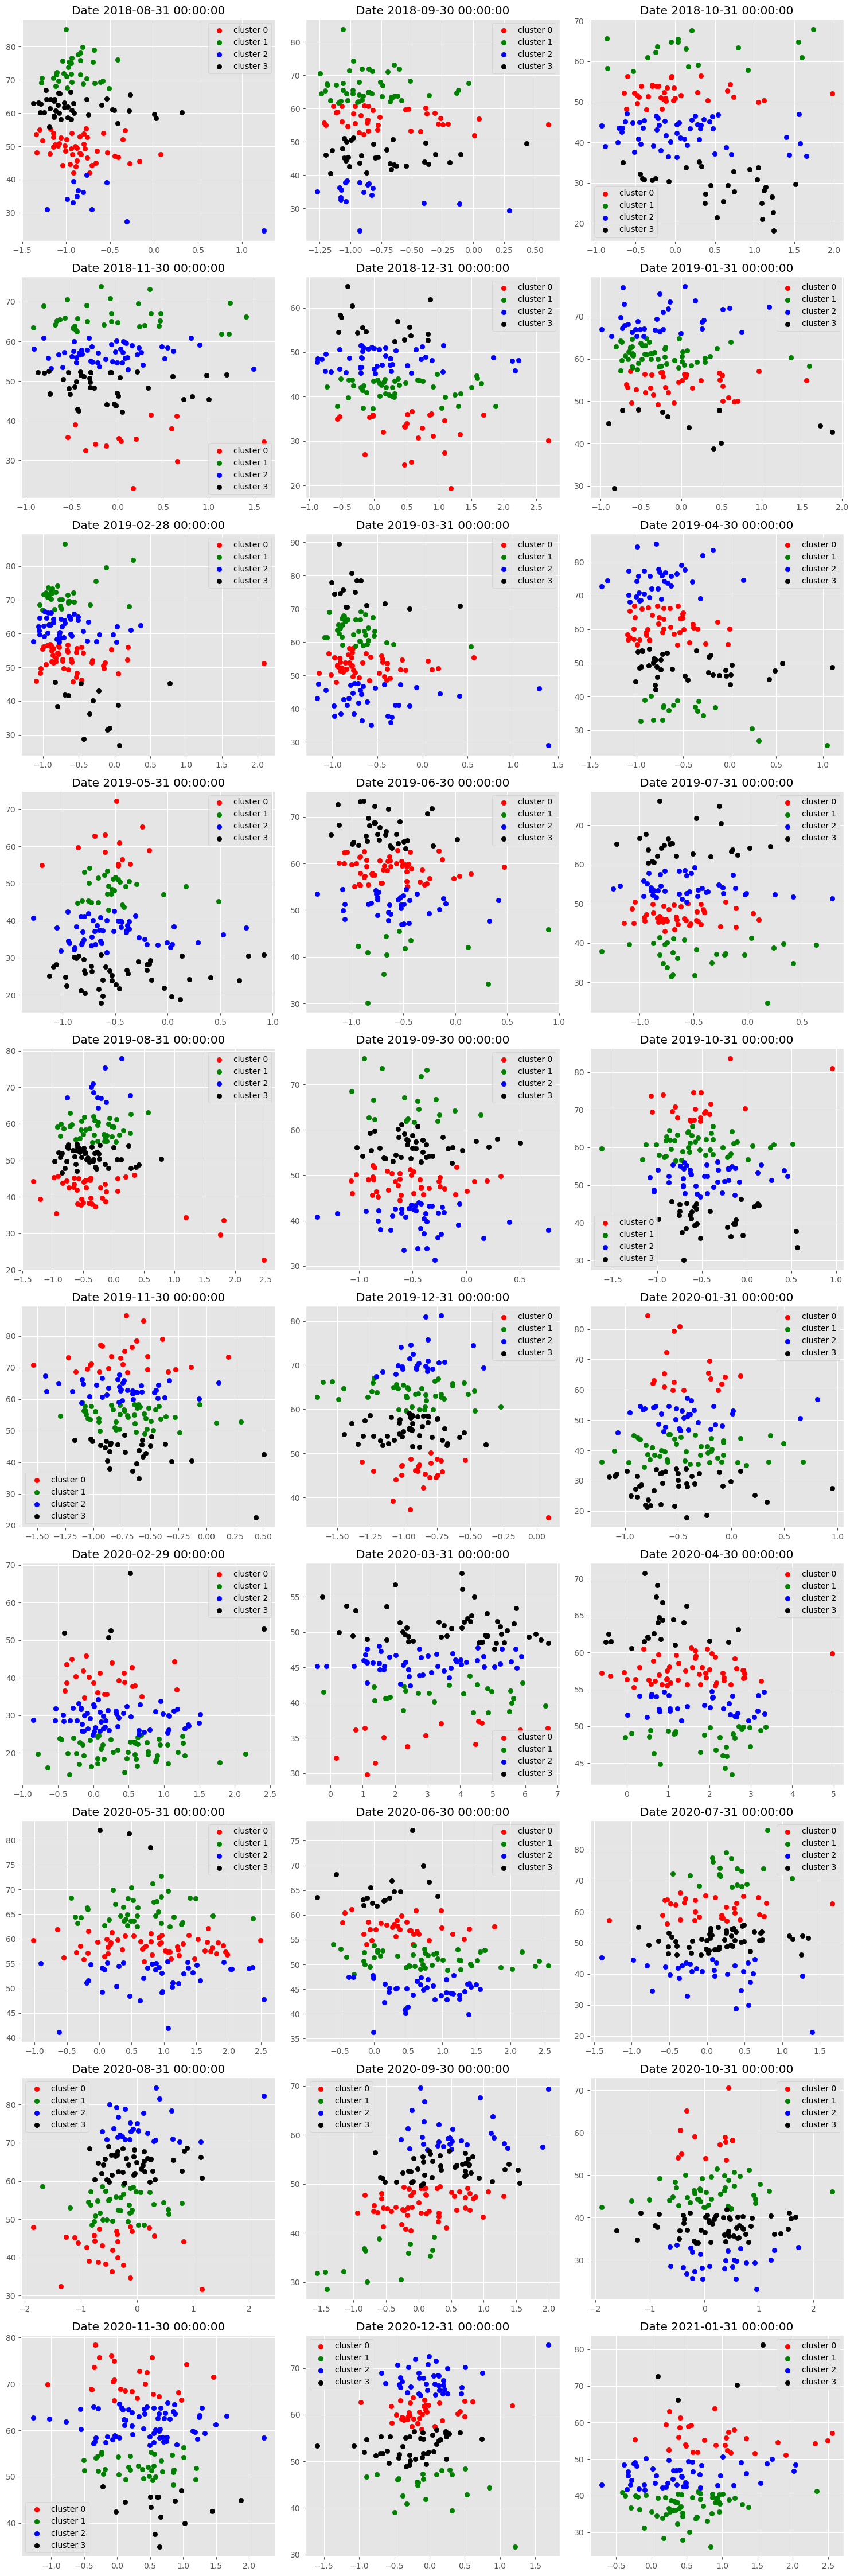

In [30]:
plot_all_clusters(data)

In [31]:
data.drop(columns='cluster', axis=1, inplace=True)

In [32]:
def initialize_centroids(target_rsi_values, num_features):
    """
    Initialize centroids for KMeans based on target RSI values.

    Parameters:
    target_rsi_values (list): List of target RSI values for centroid initialization.
    num_features (int): Number of features in the data.

    Returns:
    np.ndarray: Array of initial centroids.
    """
    centroids = np.zeros((len(target_rsi_values), num_features))
    centroids[:, 1] = target_rsi_values
    return centroids

In [33]:
initial_centroids = initialize_centroids(target_rsi_values = [32.5, 47.5, 56, 72.5], num_features = len(data.columns))
data = data.groupby(level = 'date', group_keys = False).apply(kmeans_clustering, init = initial_centroids)

In [34]:
# print(data.head())
data

garman_klass_vol        rsi    bb_low    bb_mid   bb_high  \
date       ticker                                                              
2018-08-31 AAL            -0.000024  59.763272  3.603652  3.665384  3.727116   
           AAPL           -0.000647  85.274488  3.896835  3.952077  4.007320   
           ABBV           -0.029147  48.539439  4.287913  4.314163  4.340413   
           ABT            -0.004198  66.983486  4.055374  4.091499  4.127625   
           ACN            -0.003021  68.113479  4.977965  5.015797  5.053630   
...                             ...        ...       ...       ...       ...   
2024-08-31 VRTX            0.000610  55.716051  6.179781  6.201416  6.223050   
           VZ              0.000678  55.513230  3.687818  3.729524  3.771230   
           WFC             0.000592  30.061903  4.028187  4.086512  4.144836   
           WMT             0.000512  45.326237  4.239454  4.258672  4.277890   
           XOM             0.000434  54.199766  4.710706  4.749947  4.789188   

                        atr      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2018-08-31 AAL     0.005350  0.725215   0.026445   0.034006  -0.023150   
           AAPL   -0.998356  0.432678   0.200422   0.110862   0.069227   
           ABBV   -0.645758  0.017519   0.040659   0.022996  -0.006715   
           ABT    -1.227668  0.423462   0.019835   0.049211   0.029514   
           ACN    -1.118689  0.178081   0.061131   0.016611   0.027753   
...                     ...       ...        ...        ...        ...   
2024-08-31 VRTX    1.795722  1.283314  -0.002542   0.027091   0.027855   
           VZ      0.034957  0.051459   0.011106   0.004844   0.003957   
           WFC     1.571327 -0.653599  -0.102460  -0.053013  -0.038514   
           WMT     1.267903  0.331228  -0.002622   0.005523   0.013503   
           XOM     0.816455  0.608096  -0.014419   0.007615  -0.001081   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2018-08-31 AAL     -0.046843  -0.023509   -0.007555  1.196169  1.548932   
           AAPL     0.043001   0.033036    0.028984  1.316185 -0.321427   
           ABBV    -0.027534   0.001987    0.023371  0.485008  0.480157   
           ABT      0.018801   0.020703    0.024511  0.780981 -0.119211   
           ACN      0.009652   0.015882    0.023213  1.211899 -0.193799   
...                      ...        ...         ...       ...       ...   
2024-08-31 VRTX     0.027274   0.037564    0.029621  0.496130  0.091775   
           VZ       0.009336   0.012930    0.019199  0.467060 -0.466472   
           WFC     -0.006162   0.021382    0.023281  1.092315 -0.083265   
           WMT      0.027402   0.032467    0.020547  0.622337 -0.384150   
           XOM      0.020177   0.016387    0.006383  1.060513  0.124878   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2018-08-31 AAL     0.360499  0.247598  0.816584        2  
           AAPL   -0.627322  0.418472  0.611576        3  
           ABBV   -0.209045  0.527954  0.506570        1  
           ABT    -0.429690  0.216972  0.931752        3  
           ACN    -0.257537  0.345636  0.080470        3  
...                     ...       ...       ...      ...  
2024-08-31 VRTX   -0.866033  0.130679  0.840241        2  
           VZ      0.249794  0.166856  0.191350        2  
           WFC     1.560096 -0.705912 -0.887287        0  
           WMT    -0.370368  0.197580  0.681619        1  
           XOM     0.868729 -0.502353  0.403280        2  

[10294 rows x 19 columns]

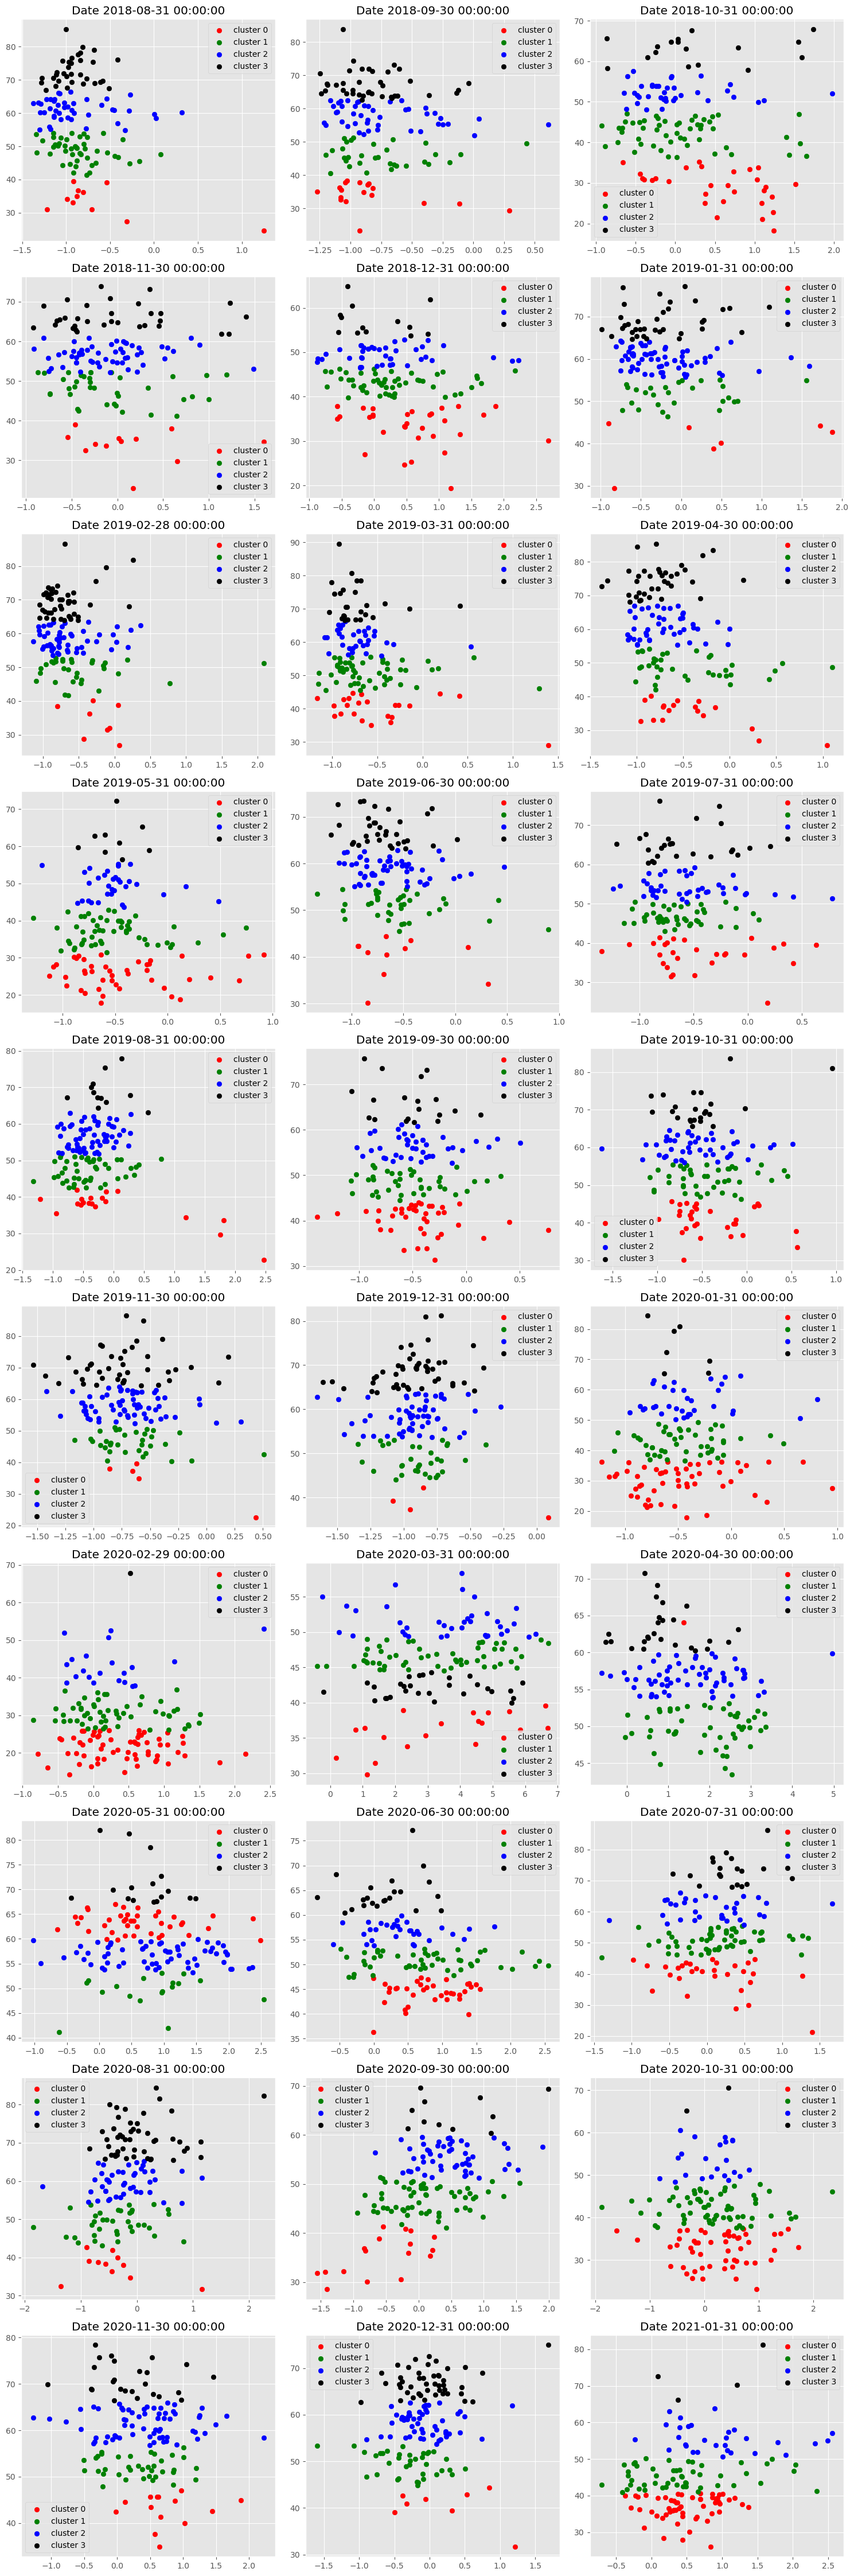

In [35]:
plot_all_clusters(data)

**Monthly Asset Selection and Portfolio Formation Based on Efficient Frontier Optimization**
- First, we will identify and select stocks from a specific cluster that aligns with our hypothesis, focusing on those exhibiting strong momentum. For instance, stocks around the RSI 72.5 centroid (i.e. cluster 3) are expected to continue their superior performance into the following month.

In [36]:
def get_cluster_dates(data, target_cluster = 3):
    """
    Process the DataFrame to filter by a specific cluster and adjust date indexing.

    Parameters:
    data (pd.DataFrame): DataFrame containing cluster information.
    target_cluster (int): The cluster to filter by.

    Returns:
    dict: Dictionary with dates as keys and lists of tickers as values.
    """
    try:
        # Filter DataFrame by target cluster and adjust indexing
        filter_df = data[data['cluster'] == target_cluster].copy()
        if filter_df.empty:
            raise ValueError(f"No data found for cluster {target_cluster}.")

        filter_df = filter_df.reset_index(level = 'ticker')
        filter_df.index = filter_df.index + pd.DateOffset(1)
        filter_df = filter_df.reset_index().set_index(['date', 'ticker'])

        # Get unique dates and prepare the dictionary with fixed dates
        dates = filter_df.index.get_level_values('date').unique()
        fixed_dates = {d.strftime('%Y-%m-%d'): filter_df.xs(d, level = 'date').index.tolist() for d in dates}

        return fixed_dates

    except Exception as e:
        raise RuntimeError(f"Error processing filtered data: {e}")

fixed_dates = get_cluster_dates(data)

- We will create a Portfolio Optimization Function that utilizes the EfficientFrontier optimizer to maximize the Sharpe ratio of our portfolio.
- The function will require the last year's price data of the selected stocks to optimize their weights.
- We will enforce constraints on individual stock weights to ensure diversification: a minimum of half the equally distributed weight and a maximum of 10% of the total portfolio.

In [37]:
def optimize_weights(prices, lower_bound = 0, upper_bound = 0.1):
    """
    Optimize portfolio weights to maximize the Sharpe ratio.

    Parameters:
    prices (pd.DataFrame): Historical price data for assets.
    lower_bound (float): Lower bound for weights (default is 0).
    upper_bound (float): Upper bound for weights (default is 0.1).

    Returns:
    dict: Dictionary of optimized asset weights.
    """
    try:
        # Ensure prices DataFrame is not empty
        if prices.empty:
            raise ValueError("The prices DataFrame is empty.")

        # Calculate expected returns and covariance matrix
        returns = expected_returns.mean_historical_return(prices = prices, frequency = 252)
        cov_matrix = risk_models.sample_cov(prices = prices, frequency = 252)

        # Initialize Efficient Frontier with bounds
        ef = EfficientFrontier(expected_returns = returns, cov_matrix = cov_matrix, 
                               weight_bounds = (lower_bound, upper_bound), 
                               solver='SCS')

        # Optimize for maximum Sharpe ratio
        optimal_weights = ef.max_sharpe()

        # Clean and return the weights
        return ef.clean_weights()

    except Exception as e:
        raise RuntimeError(f"Error optimizing weights: {e}")

In [38]:
# Download Fresh Daily Prices Data only for short listed stocks.
def download_stock_data(data):
    """
    Download fresh daily price data for a list of stocks based on the provided DataFrame.

    Parameters:
    data (pd.DataFrame): DataFrame containing stock tickers and dates.

    Returns:
    pd.DataFrame: DataFrame with the downloaded stock price data.
    """
    try:
        # Ensure 'ticker' and 'date' are available and non-empty
        if 'ticker' not in data.index.names or 'date' not in data.index.names:
            raise ValueError("The DataFrame must have 'ticker' and 'date' as index levels.")

        # Extract unique tickers and date range
        tickers = data.index.get_level_values('ticker').unique().tolist()
        dates = data.index.get_level_values('date').unique()

        if not tickers or dates.empty:
            raise ValueError("No 'tickers' or 'dates' found in the DataFrame.")

        start_date = dates.min() - pd.DateOffset(months = 12)
        end_date = dates.max()

        # Download stock price data
        new_df = yf.download(tickers = tickers, start = start_date, end = end_date)

        # Check if download was successful
        if new_df.empty:
            raise ValueError("The downloaded DataFrame is empty. Please check the ticker symbols and date range.")

        return new_df

    except Exception as e:
        raise RuntimeError(f"Error downloading stock data: {e}")

# Download fresh data for short listed stocks.
fresh_data = download_stock_data(data)

[*********************100%%**********************]  154 of 154 completed


In [39]:
# print(fresh_data.head())
fresh_data

Price       Adj Close                                                  \
Ticker            AAL        AAPL        ABBV         ABT         ACN   
Date                                                                    
2017-08-31  43.511292   38.485268   55.412045   45.090458  117.201660   
2017-09-01  44.065639   38.496994   55.500351   45.302895  116.610092   
2017-09-05  42.713810   38.034718   55.375248   45.170116  116.314301   
2017-09-06  43.093105   37.994812   56.699829   45.311749  117.524338   
2017-09-07  42.636009   37.842293   60.180553   45.577290  120.320816   
...               ...         ...         ...         ...         ...   
2024-08-15  10.090000  224.720001  193.399994  110.940002  325.130005   
2024-08-16  10.050000  226.050003  193.899994  111.000000  326.920013   
2024-08-19  10.310000  225.889999  196.869995  111.900002  329.440002   
2024-08-20  10.290000  226.509995  196.149994  110.769997  330.369995   
2024-08-21  10.355000  226.360001  196.009995  110.764999  331.295013   

Price                                                                  ...  \
Ticker            ADBE         ADI         ADP        ADSK        AIG  ...   
Date                                                                   ...   
2017-08-31  155.160004   73.146118   91.848152  114.459999  50.215801  ...   
2017-09-01  155.059998   73.766815   92.607307  113.709999  50.398472  ...   
2017-09-05  154.279999   72.560379   91.813637  113.769997  49.526669  ...   
2017-09-06  153.759995   72.132027   93.211159  113.790001  49.377232  ...   
2017-09-07  155.470001   71.288177   94.459984  114.050003  48.380875  ...   
...                ...         ...         ...         ...        ...  ...   
2024-08-15  554.159973  223.669998  263.660004  250.210007  73.419998  ...   
2024-08-16  553.460022  223.190002  264.089996  248.229996  73.559998  ...   
2024-08-19  563.119995  225.949997  264.649994  251.110001  74.430000  ...   
2024-08-20  562.250000  223.490005  264.540009  250.130005  73.879997  ...   
2024-08-21  560.565002  229.039993  265.799988  250.899994  73.790001  ...   

Price         Volume                                                           \
Ticker             V      VLO     VRTX        VZ       WBA      WDC       WFC   
Date                                                                            
2017-08-31  13766000  4434400  3329500  14237700   5025000  4599900  25231100   
2017-09-01   4466800  3954400  1708700  11455200   5335500  3467700  16217700   
2017-09-05   6337500  4581400  1327000  10005100   5412200  3182300  31251300   
2017-09-06   6372200  4428800  1328400  14081900   5428200  4215500  26854000   
2017-09-07   6508600  3675900  1236000  16591100   5467400  2569600  23367300   
...              ...      ...      ...       ...       ...      ...       ...   
2024-08-15   7397800  1917700  1307200  17489600   9061900  5661400  16549400   
2024-08-16   5111100  2005500  1181300  13377500  11044200  4496800  19173900   
2024-08-19   6555900  2637900   895800   9401400  12516600  5147100  12792900   
2024-08-20   6802900  4082800   921800   8781100  12692400  3704300  12532400   
2024-08-21    687369   665623   127671   1882339   4352668   932272   2498102   

Price                                    
Ticker           WMT     WYNN       XOM  
Date                                     
2017-08-31  24584400  2629700  15641700  
2017-09-01  19423200  3014100   7361100  
2017-09-05  36205500  1836000  12784800  
2017-09-06  25278300  1817300  18574400  
2017-09-07  20462400  1860700   9836400  
...              ...      ...       ...  
2024-08-15  49567500  2778700  11579400  
2024-08-16  19872100  1822800  10056000  
2024-08-19  13709300  3310500  12417500  
2024-08-20  14418100  1837300  15627500  
2024-08-21   4754764   415570   2604576  

[1754 rows x 924 columns]

In [40]:
# Calculate daily returns for each potential stock in our portfolio.
# At the start of each month, use the function to select stocks and calculate their optimal weights for the upcoming month.
# In cases where the maximum Sharpe ratio optimization fails, default to equally-weighted weights for that month.

def calculate_monthly_returns(fresh_data, fixed_dates):
    """
    Calculate the monthly returns for each potential stock in the portfolio and optimize weights.

    Parameters:
    fresh_data (pd.DataFrame): Historical stock price data.
    fixed_dates (dict): Dictionary with dates as keys and lists of tickers as values.

    Returns:
    pd.DataFrame: DataFrame with portfolio returns for each month.
    """
    try:
        # Calculate daily log returns
        returns_dataframe = np.log(fresh_data['Adj Close']).diff()

        # Prepare an empty DataFrame to store the portfolio returns
        portfolio_df = pd.DataFrame()

        # Iterate over each start date in fixed_dates
        for start_date in fixed_dates.keys():

            if pd.to_datetime(start_date) > fresh_data.index.get_level_values('Date').max():
                break;
            try:
                end_date = (pd.to_datetime(start_date) + pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')
                optimization_start_date = (pd.to_datetime(start_date) - pd.DateOffset(months = 12)).strftime('%Y-%m-%d')
                optimization_end_date = (pd.to_datetime(start_date) - pd.DateOffset(days = 1)).strftime('%Y-%m-%d')

                # Extract the data for optimization
                cols = fixed_dates[start_date]
                optimization_df = fresh_data[optimization_start_date: optimization_end_date]['Adj Close'][cols]

                # Optimize weights and handle exceptions
                success = False
                try:
                    weights = optimize_weights(prices = optimization_df, 
                                               lower_bound = round(1 / (len(optimization_df.columns) * 2), 3))
                    weights = pd.DataFrame(weights, index = pd.Series(0))
                    success = True
                except Exception as e:
                    print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights')
                if not success:
                    # If optimization failed, use equal weights
                    weights = pd.DataFrame([1 / len(optimization_df.columns) for i in range(len(optimization_df.columns))], 
                                        index = optimization_df.columns.tolist(), 
                                        columns = pd.Series(0)).T

                # Calculate returns for the current month
                temp_df = returns_dataframe[start_date: end_date]
                temp_df = (temp_df
                        .stack()
                        .to_frame('return')
                        .reset_index(level = 0)
                        .merge(weights.stack()
                                .to_frame('weight')
                                .reset_index(level = 0, drop = True), left_index = True, right_index = True)
                        .reset_index()
                        .set_index(['Date', 'Ticker'])
                        .unstack()
                        .stack(future_stack = True)
                        )
                temp_df.index.names = ['date', 'ticker']
                temp_df['weighted_return'] = temp_df['return'] * temp_df['weight']
                temp_df = temp_df.groupby(level = 0)['weighted_return'].sum().to_frame('Strategy Return')
                portfolio_df = pd.concat([portfolio_df, temp_df], axis = 0)
            except Exception as e:
                raise RuntimeError(f'Error in {start_date}: {e}')

        return portfolio_df.drop_duplicates()

    except Exception as e:
        raise RuntimeError(f"Error in calculate_monthly_returns: {e}")

portfolio_df = calculate_monthly_returns(fresh_data, fixed_dates)

Max Sharpe Optimization failed for 2019-06-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2020-02-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2020-03-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2020-04-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2020-11-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2021-02-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2021-10-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-05-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-09-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-10-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2023-02-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2023-11-01, Continuing with Equal-Weights


In [41]:
portfolio_df

,Strategy Return
date,
2018-09-04,0.009794
2018-09-05,-0.011432
2018-09-06,-0.001392
2018-09-07,0.002061
2018-09-10,0.006280
...,...
2024-08-15,0.002666
2024-08-16,0.001566
2024-08-19,0.000593


- Plot the monthly returns of our optimized portfolio and compare them with the monthly returns of the S&P 500.

In [42]:
def download_and_process_spy_data(start_date, end_date, portfolio_df):
    """
    Download SPY data, calculate returns, and merge with the portfolio DataFrame.

    Parameters:
    start_date (str): Start date for downloading SPY data.
    end_date (str): End date for downloading SPY data.
    portfolio_df (pd.DataFrame): Existing portfolio DataFrame to merge with.

    Returns:
    pd.DataFrame: Updated portfolio DataFrame with SPY returns.
    """
    try:
        # Download SPY data
        SPY500 = yf.download(tickers = 'SPY', start = start_date, end = end_date)

        if SPY500.empty:
            raise ValueError("Downloaded SPY data is empty. Check the ticker symbol and date range.")

        # Calculate daily returns and rename column
        SPY500_returns = np.log(SPY500[['Adj Close']]).diff().dropna().rename(columns = {'Adj Close': 'S&P500 Buy&Hold'})

        # Merge with portfolio_df
        updated_portfolio_df = portfolio_df.merge(SPY500_returns, left_index = True, right_index = True)

        return updated_portfolio_df

    except Exception as e:
        raise RuntimeError(f"Error processing SPY data: {e}")

start_date = '2016-01-01'
end_date = dt.date.today().strftime('%Y-%m-%d')
portfolio_df = download_and_process_spy_data(start_date, end_date, portfolio_df)


[*********************100%%**********************]  1 of 1 completed


In [43]:
def plot_cumulative_returns(portfolio_df, end_date = '2024-08-02'):
    """
    Plot the cumulative returns of the optimized portfolio and compare with the S&P 500.

    Parameters:
    portfolio_df (pd.DataFrame): DataFrame containing portfolio returns.
    end_date (str): End date for plotting the cumulative returns.
    """
    try:
        # Check if the DataFrame contains required data
        if portfolio_df.empty:
            raise ValueError("The portfolio DataFrame is empty. Cannot plot cumulative returns.")

        # Calculate cumulative returns
        portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum()) - 1

        # Filter data up to the specified end date
        end_date = pd.to_datetime(end_date)
        filtered_data = portfolio_cumulative_return.loc[: end_date]

        # Plotting
        plt.style.use('ggplot')
        plt.figure(figsize = (21, 9))
        filtered_data.plot(figsize = (21, 9))

        plt.title('Cumulative Returns of Optimized Portfolio vs. S&P 500')
        plt.xlabel('Date')
        plt.ylabel('Cumulative Return')
        plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax = 1.0))
        plt.grid(True)
        plt.legend(['Optimized Portfolio', 'S&P 500'], loc = 'best')
        #plt.tight_layout()

        plt.show()

    except Exception as e:
        raise RuntimeError(f"Error plotting cumulative returns: {e}")

<Figure size 2100x900 with 0 Axes>

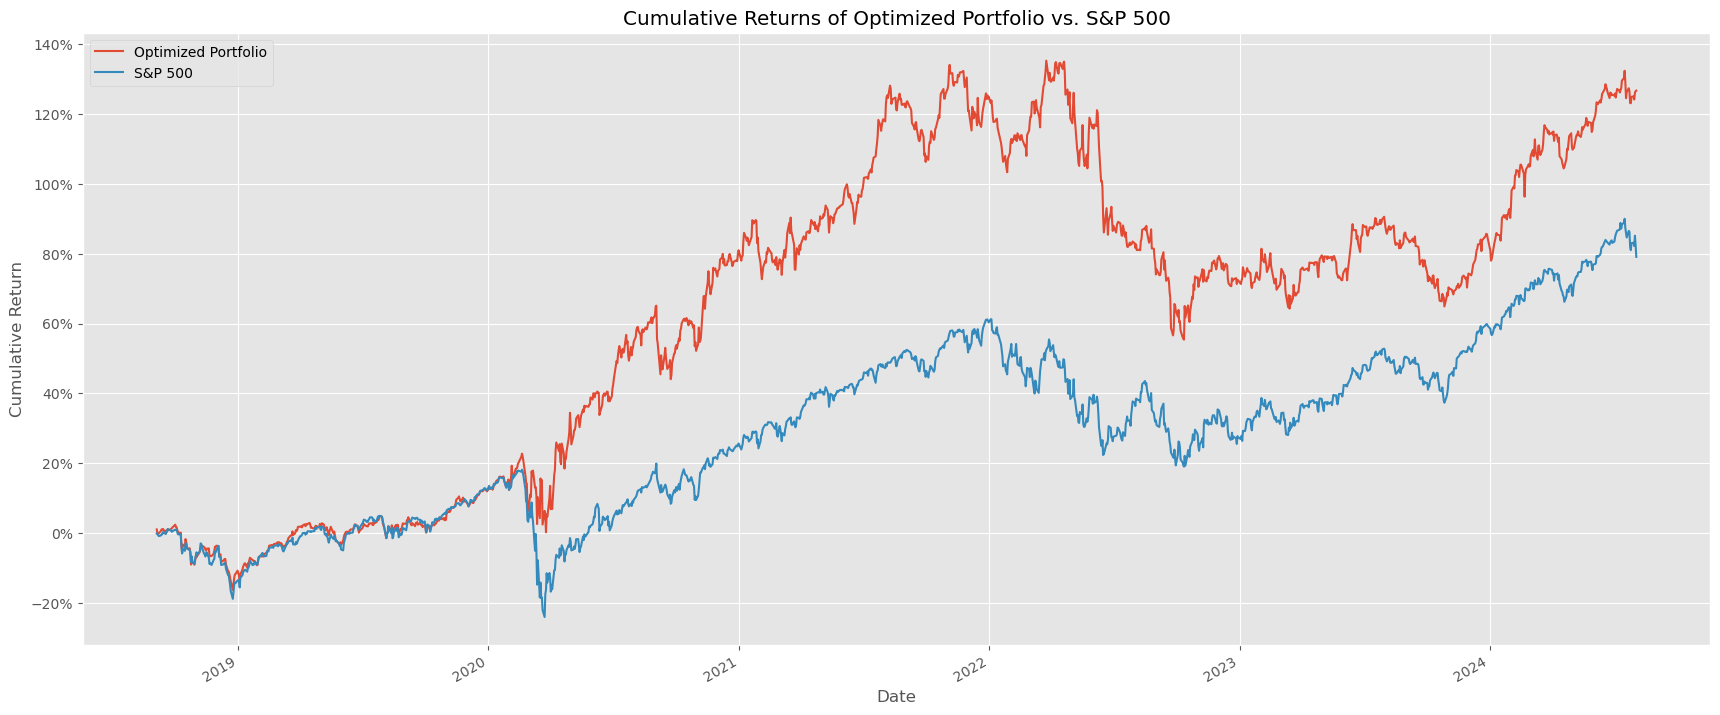

In [44]:
plot_cumulative_returns(portfolio_df)